# K Nearest Neighbors Project

You've been given a classified data set from a company! They've hidden the feature column names but have given you the data and the target classes.

I'll use KNN to create a model that directly predicts a class for a new data point based off of the features.

## Set up

Import required libraries

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Read the dataset

In [47]:
df = pd.read_csv('KNN_Project_Data')
df.head()

XVPM         GWYH         TRAT        TLLZ         IGGA  \
0  1636.670614   817.988525  2565.995189  358.347163   550.417491   
1  1013.402760   577.587332  2644.141273  280.428203  1161.873391   
2  1300.035501   820.518697  2025.854469  525.562292   922.206261   
3  1059.347542  1066.866418   612.000041  480.827789   419.467495   
4  1018.340526  1313.679056   950.622661  724.742174   843.065903   

          HYKR         EDFS        GUUB         MGJM         JHZC  \
0  1618.870897  2147.641254  330.727893  1494.878631   845.136088   
1  2084.107872   853.404981  447.157619  1193.032521   861.081809   
2  2552.355407   818.676686  845.491492  1968.367513  1647.186291   
3   685.666983   852.867810  341.664784  1154.391368  1450.935357   
4  1370.554164   905.469453  658.118202   539.459350  1899.850792   

   TARGET CLASS  
0             0  
1             1  
2             1  
3             0  
4             0

## Exploratory Data Analysis

Because this data is artificial and column information is hidden, there is not much point in trying to establish some early connections based on reason and intuition. Instead, let's explore general relationships in the dataset among variables, but segregated by the target class column.

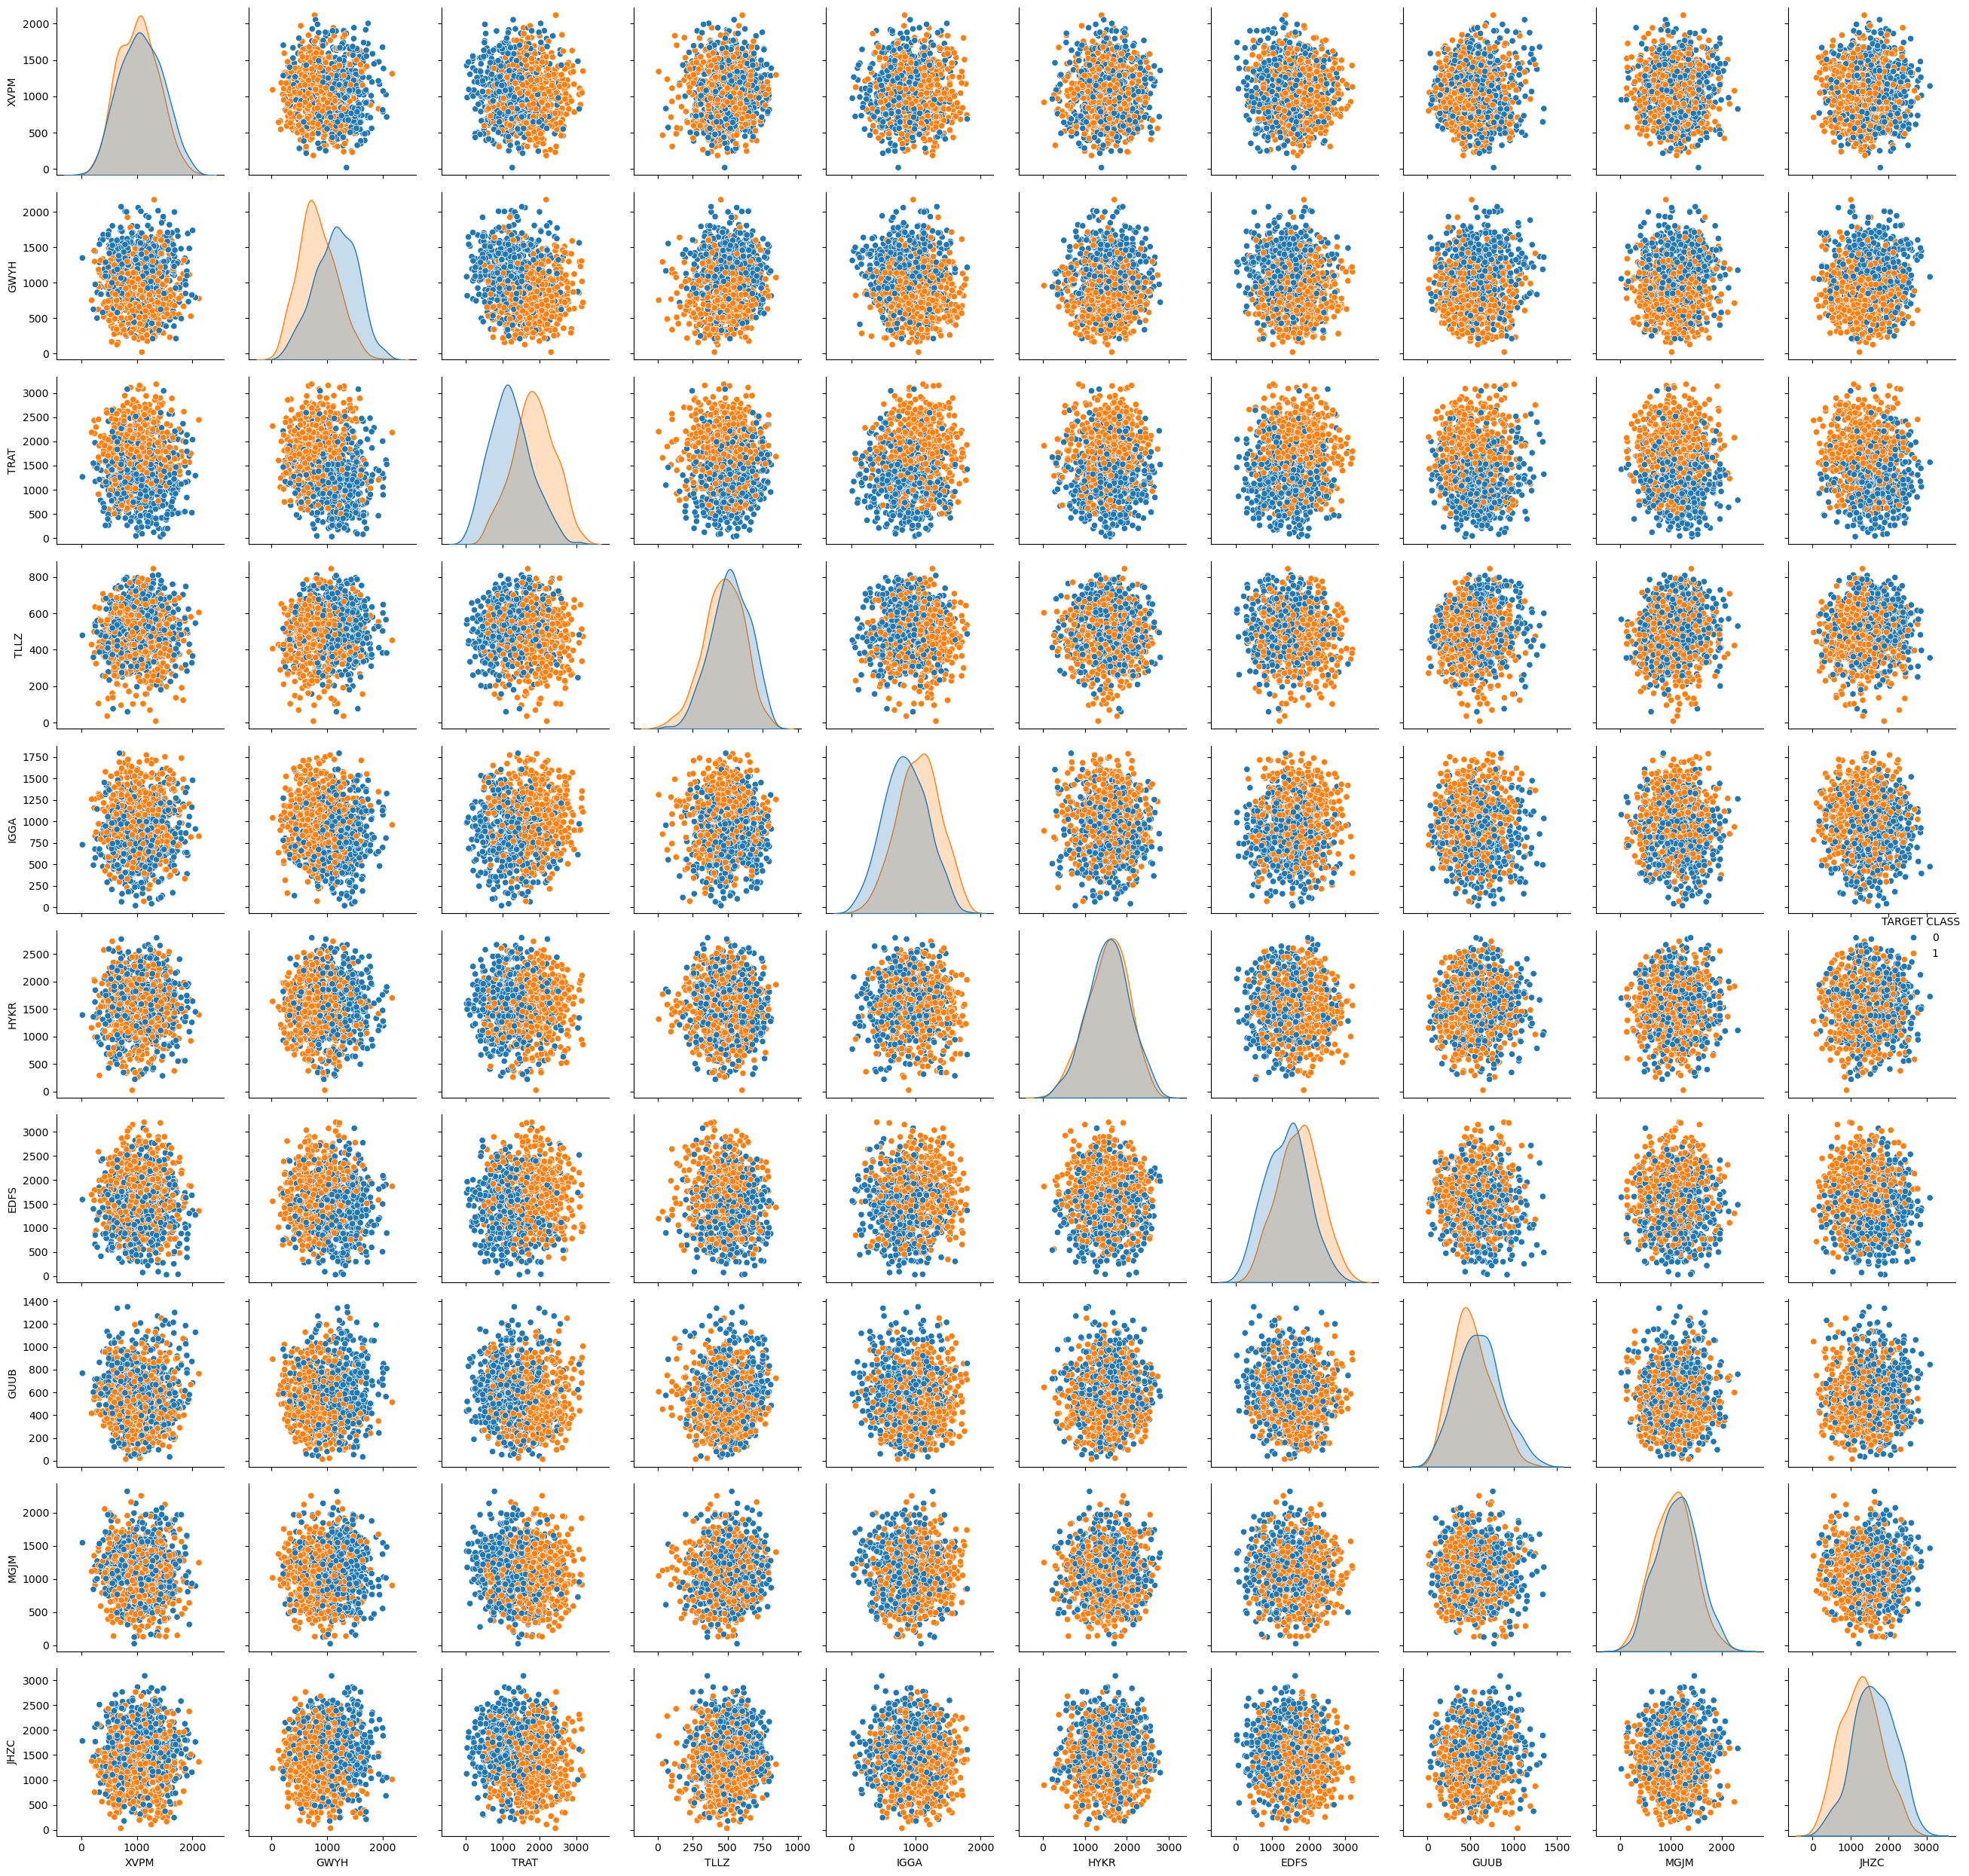

In [72]:
sns.pairplot(df, hue = 'TARGET CLASS')
plt.tight_layout()

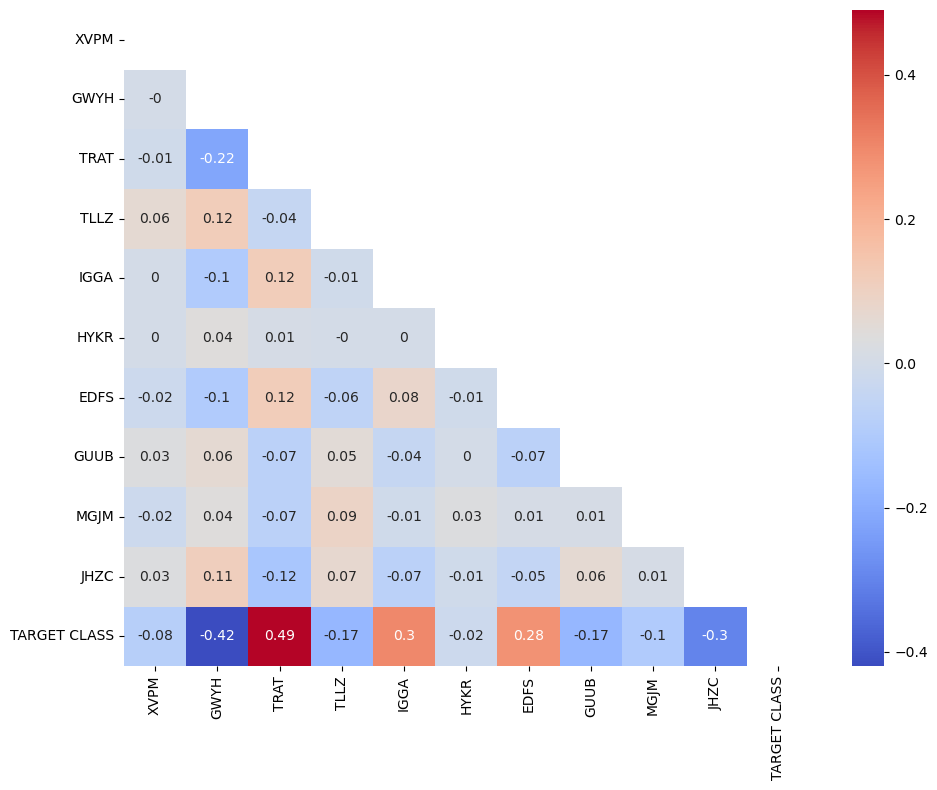

In [49]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))

sns.heatmap(corr.round(2), 
            annot= True, 
            cmap = 'coolwarm',
           mask=mask)
plt.tight_layout()

Overall, the first plot shows some clear segregation of the data across some features, like TRAT or GWYH, while the mix is more homogenously across features like HYKR. This could potentially indicate the strength of these variables as predictors.

The second plot highlights some of this intuition when looking at the TARGET CLASS row. Importantly, there is no strong correlation among the features, so there will likely be no multicollinearity issues in our model.

## Stardardise the variables

For these types of classification that rely on distance, the magnitude of the different metrics can significantly influence the inference. So, it is really important to standardise the values so each predictor has potentially similar chances of influencing the response a priori (that is, not biased by the magnitude of the measurement).

In [50]:
from sklearn.preprocessing import StandardScaler

In [51]:
scaler = StandardScaler()

In [52]:
# Fit the scaler to the features
scaler.fit(df.drop('TARGET CLASS', axis = 1))

StandardScaler()

In [53]:
# Transform the features to the scaled version
scaled_features = scaler.transform(df.drop('TARGET CLASS', axis = 1))

In [54]:
# Compile the scaled variables into a new dataframe we can use for the model
df_feat_scaled = pd.DataFrame(scaled_features, columns = df.columns[:-1])
df_feat_scaled.head()

XVPM      GWYH      TRAT      TLLZ      IGGA      HYKR      EDFS  \
0  1.568522 -0.443435  1.619808 -0.958255 -1.128481  0.138336  0.980493   
1 -0.112376 -1.056574  1.741918 -1.504220  0.640009  1.081552 -1.182663   
2  0.660647 -0.436981  0.775793  0.213394 -0.053171  2.030872 -1.240707   
3  0.011533  0.191324 -1.433473 -0.100053 -1.507223 -1.753632 -1.183561   
4 -0.099059  0.820815 -0.904346  1.609015 -0.282065 -0.365099 -1.095644   

       GUUB      MGJM      JHZC  
0 -0.932794  1.008313 -1.069627  
1 -0.461864  0.258321 -1.041546  
2  1.149298  2.184784  0.342811  
3 -0.888557  0.162310 -0.002793  
4  0.391419 -1.365603  0.787762

## Train-Test split

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
X = df_feat_scaled
y = df['TARGET CLASS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Fit the KNN model

In [57]:
from sklearn.neighbors import KNeighborsClassifier

Let's start with k = 1 and will refine the model after

In [58]:
knn = KNeighborsClassifier(n_neighbors = 1)

In [59]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

### Predictions and Evaluations

In [60]:
from sklearn.metrics import confusion_matrix, classification_report

In [61]:
pred = knn.predict(X_test)

In [62]:
print('Initial model: K = 1')
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test, pred))
print('\n')
print('Classification report:')
print(classification_report(y_test, pred))

Initial model: K = 1


Confusion matrix:
[[119  44]
 [ 50 117]]


Classification report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.72       163
           1       0.73      0.70      0.71       167

    accuracy                           0.72       330
   macro avg       0.72      0.72      0.72       330
weighted avg       0.72      0.72      0.72       330



With K = 1, we get quite a bit of false positives and false negatives (94 in total) and the classification report shows only a 72% accuracy. This is expected because the K is very low, so we can definetely improve it by choosing a more optimal K value.

### Choosing an optimal K value

Let's train a range of different KNN models based on an increasing K value to evaluate which K value is optimal for our model. This is commonly referred to as **the elbow method**.

This is achieved by creating a for loop that trains various KNN models with different k values, then keeps track of the error_rate for each of these models with a list. Refer to the lecture if you are confused on this step.*

In [67]:
error_rate = []

for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

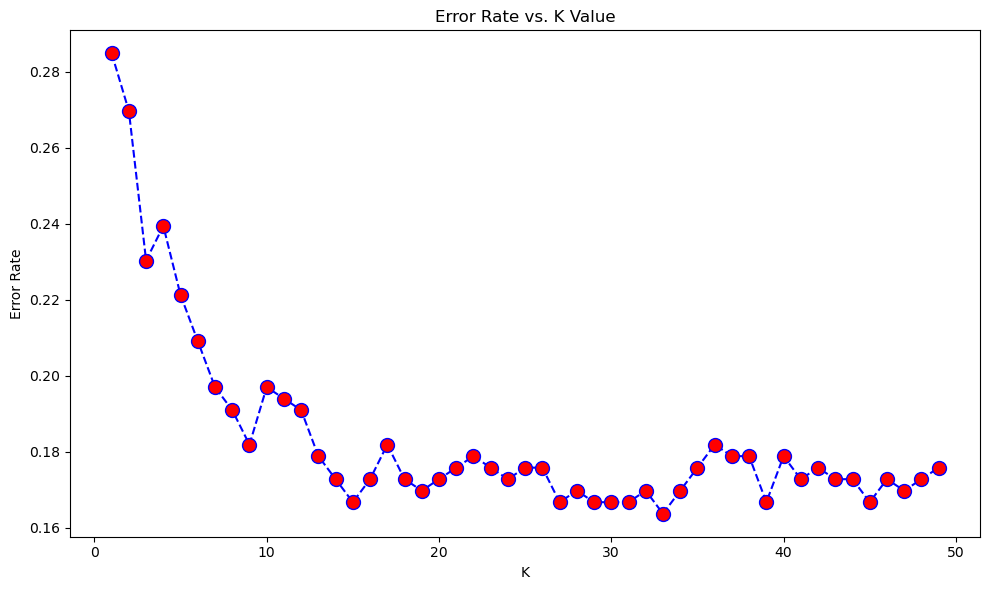

In [68]:
plt.figure(figsize = (10,6))
plt.plot(range(1,50), error_rate,
         color = 'blue',
         linestyle = '--',
         marker = 'o',
         markerfacecolor = 'red', 
         markersize = 10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.tight_layout()

From this analysis, it is clear that the error stabilises around K = 18-20. I wil choose K = 19 to refit the model.

### Fit KNN model with optimised K Value

In [65]:
knn = KNeighborsClassifier(n_neighbors = 19)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

print('Optimised model: K = 19')
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test, pred))
print('\n')
print('Classification report:')
print(classification_report(y_test, pred))

Optimised model: K = 19


Confusion matrix:
[[139  24]
 [ 32 135]]


Classification report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       163
           1       0.85      0.81      0.83       167

    accuracy                           0.83       330
   macro avg       0.83      0.83      0.83       330
weighted avg       0.83      0.83      0.83       330



In [66]:
print('Optimisation summary:')
print('\n')
print('    False negative drops from 50 to 32. That is 36% reduction, indicating improved recall')
print('    False positive drops from 44 to 24. That is 45.5% reduction, indicating improved precision')
print('    F1 score shift from 0.72 with K = 1 to 0.83 with K = 19')
print('    Accuracy improved from 72% to 83%')

Optimisation summary:


    False negative drops from 50 to 32. That is 36% reduction, indicating improved recall
    False positive drops from 44 to 24. That is 45.5% reduction, indicating improved precision
    F1 score shift from 0.72 with K = 1 to 0.83 with K = 19
    Accuracy improved from 72% to 83%
